In [1]:
'''
2IMP40 Data Science for Software Engineering
Design A Study assignment group 6
Data collection and cleaning notebook
''';

In [2]:
import pandas as pd
from pymongo import MongoClient

connection = MongoClient(
    host="research.cassee.dev",
    username="read-shark",
    password="msr2021shark")

db = connection.smartshark_2_1

In [3]:
# Query
data = list(db.issue.aggregate([{
           '$lookup':
             {
               'from': 'people',
               'localField': 'creator_id',
               'foreignField': '_id',
               'as': 'people'
             }},
            {
                '$unwind': '$people'
            },
            {
            '$lookup': {
                'from': 'issue_system',
                'localField': 'issue_system_id',
                'foreignField': '_id',
                'as': 'issue_system'
                }
            },
            {
                '$unwind': '$issue_system'
            },
            {
            '$project': {
                '_id': 1, 
                'project_id': '$issue_system.project_id',
                'title': 1, 
                'issue_type': 1, 
                'issue_type_verified': 1, 
                'priority': 1, 
                'status': 1, 
                'created_at': 1,
                'updated_at': 1,
                'resolution': 1, 
                'desc': 1,
                'assignee_id': 1,
                'reporter_id': 1,
                'creator_id': '$people._id',
                'email': '$people.email',
                'name': '$people.name',
                'username': '$people.username'
            }
            }
        ]))

In [4]:
# Convert to dataframe
df = pd.DataFrame(data)

print(len(df.index))
df.head()

157811


,_id,title,desc,created_at,updated_at,reporter_id,issue_type,priority,status,assignee_id,project_id,creator_id,email,name,username,resolution,issue_type_verified
0,58bfca910ccb2667fe269dd1,Do Application based outstanding request throt...,Moved from SourceForge to Apache.\nhttp://sour...,2008-06-10 21:30:20.234,2008-06-10 21:30:20.234,58b938adf04620b395fccf94,New Feature,Major,Open,58b938adf04620b39bfccf95,5ca4c6b26bcebe2f4003c6e4,58b938adf04620b395fccf94,phunt@apache.org,Patrick Hunt,phunt,NaN,NaN
1,58bfca920ccb2667fe269dd2,Replay logs,Moved from SourceForge to Apache.\nhttp://sour...,2008-06-10 22:38:04.807,2008-06-10 22:38:04.807,58b938adf04620b395fccf94,New Feature,Major,Open,NaN,5ca4c6b26bcebe2f4003c6e4,58b938adf04620b395fccf94,phunt@apache.org,Patrick Hunt,phunt,NaN,NaN
2,58bfca930ccb2667fe269dd3,WebDAV access to ZooKeeper,Moved from SourceForge to Apache.\nhttp://sour...,2008-06-10 22:41:06.723,2008-06-10 22:41:06.723,58b938adf04620b395fccf94,New Feature,Major,Open,58b938adf04620b395fccf94,5ca4c6b26bcebe2f4003c6e4,58b938adf04620b395fccf94,phunt@apache.org,Patrick Hunt,phunt,NaN,NaN
3,58bfca930ccb2667fe269dd4,Clients should check the latencies to the vari...,When ZooKeeper clients and servers are on the ...,2008-06-17 14:56:48.591,2008-06-17 14:57:32.124,58b938adf04620b39bfccf95,Improvement,Major,Open,NaN,5ca4c6b26bcebe2f4003c6e4,58b938adf04620b39bfccf95,breed@apache.org,Benjamin Reed,breed,NaN,NaN
4,58bfca940ccb2667fe269dd7,Session ids on the stat cmd information,Currently there is not a way to correlate sess...,2008-06-25 15:34:15.116,2008-06-25 15:34:15.116,58b938adf04620b39bfccf95,Improvement,Minor,Open,NaN,5ca4c6b26bcebe2f4003c6e4,58b938adf04620b39bfccf95,breed@apache.org,Benjamin Reed,breed,NaN,NaN


## Issue Types (Verified)

In [5]:
# Combine issue type and issue type verified, such that if there is a verified type we pick that, otherwise keep the original issue type
df['new_issue_type'] = df['issue_type_verified'].combine_first(df['issue_type'])

# drop the old issue types and rename new_issue_type to issue_type
df = df.drop(columns = ['issue_type', 'issue_type_verified'])
df = df.rename(columns={'new_issue_type': 'issue_type'})

In [6]:
# put all issue types in lowercase
df['issue_type'] = df['issue_type'].apply(lambda x: x.lower())
print("All issue type currently present:\n", df['issue_type'].value_counts(dropna=False))

# grouping of values which mean the same but have different labels
feature_equivs = ['improvement', 'new feature', 'wish', 'feature_request', 'request', 'proposal']
feature_val = 'feature'
task_equivs = ['sub-task', 'task', 'technical task']
task_val = 'task'
dependency_equivs = ['dependency upgrade', 'dependency']
dep_val = 'dependency'
other_equivs = ['other', 'epic', 'refactoring', 'temp', 'umbrella', 'story', 'blog - new blog request', 'tck challenge', 'it help', 'new jira project', 'access', 'blogs - new blog user account request', 'project', 'outage', 'new tlp ', 'new git repo', 'planned work', 'brainstorming', 'dependency upgrade', 'dependency', 'question']
other_val = 'thrash'


# mainly not sure what to do with: test, documentation, question, epic, refactoring, temp and umbrella

df['issue_type'] = df['issue_type'].apply(lambda val: feature_val if val in feature_equivs else val) 
df['issue_type'] = df['issue_type'].apply(lambda val: task_val if val in task_equivs else val) 
df['issue_type'] = df['issue_type'].apply(lambda val: dep_val if val in dependency_equivs else val) 
df['issue_type'] = df['issue_type'].apply(lambda val: other_val if val in other_equivs else val) 

df = df[df['issue_type'] != other_val]

print("\nCombined issue types:\n", df['issue_type'].value_counts(dropna=False))

All issue type currently present:
 bug                                      81227
improvement                              42197
new feature                               9585
sub-task                                  9501
task                                      8436
test                                      1739
wish                                      1397
other                                     1227
documentation                             1080
feature_request                            549
question                                   310
dependency upgrade                         153
epic                                       133
refactoring                                 92
story                                       56
temp                                        31
umbrella                                    24
brainstorming                               20
dependency                                  18
blog - new blog request                      6
technical task           

### Status

In [7]:
print("Initial unique status values\n", df['status'].value_counts(dropna=False))

# All issues have a statement (i.e. no nan values), interestingly blocked only occurs twice
# We'll only look at closed and resolved issues
df = df[(df['status'] == 'Closed') | (df['status'] == 'Resolved')]

print("\nFiltered status\n", df['status'].value_counts(dropna=False))

Initial unique status values
 Closed             79445
Resolved           47321
Open               26544
Patch Available     1106
Reopened             699
In Progress          606
Blocked                2
Name: status, dtype: int64

Filtered status
 Closed      79445
Resolved    47321
Name: status, dtype: int64


### Resolution

In [8]:
print("Initial unique resolution values:\n", df['resolution'].value_counts(dropna=False))

# grouping of values which mean the same but have different labels
resolved_equivs = ['Fixed', 'Done', 'Resolved', 'Workaround', 'Delivered', 'Implemented', 'Staged']
resolved_val = 'Resolved'
unresolved_equivs = ["Won't Fix", 'Not A Bug', 'Works for Me', 'Cannot Reproduce', 'Auto Closed', "Won't Do", "Abandoned", 'Unresolved', 'Pending Closed']
unresolved_val = 'Unresolved'
invalid_equivs = ['Duplicate', 'Not A Problem', 'Invalid', 'Incomplete', 'REMIND', 'Later', 'Information Provided', 'Feedback Received']
invalid_val = 'Invalid'

df['resolution'] = df['resolution'].apply(lambda val: resolved_val if val in resolved_equivs else val) 
df['resolution'] = df['resolution'].apply(lambda val: unresolved_val if val in unresolved_equivs else val) 
df['resolution'] = df['resolution'].apply(lambda val: invalid_val if val in invalid_equivs else val) 
df['resolution'] = df['resolution'].apply(lambda val: invalid_val if str(val) == 'nan' else val)  # drop nans as .dropna() doesn't seem to work
df['resolution'] = df['resolution'].dropna()
df = df[df['resolution'] != invalid_val]

print("\nCombined unique resolution values:\n", df['resolution'].value_counts(dropna=False))

Initial unique resolution values:
 Fixed                   97796
Won't Fix                6969
Duplicate                6863
Not A Problem            4191
Invalid                  3081
Cannot Reproduce         2517
Incomplete               2455
Done                      973
Implemented               340
Not A Bug                 322
Resolved                  294
Later                     286
Auto Closed               180
Won't Do                  128
Abandoned                 102
Information Provided       72
Workaround                 72
Unresolved                 47
Pending Closed             39
Works for Me               16
Feedback Received           9
Delivered                   7
NaN                         4
REMIND                      2
Staged                      1
Name: resolution, dtype: int64

Combined unique resolution values:
 Resolved      99483
Unresolved    10320
Name: resolution, dtype: int64


## Descriptions

In [9]:
df = df[df['desc'] != '']
df = df[~df['desc'].isnull()]
df_plot = df
df_plot['desc_length'] = df_plot['desc'].str.len()
df_plot['desc_length'].describe()

count    1.008490e+05
mean     9.602492e+02
std      6.235314e+03
min      1.000000e+00
25%      1.790000e+02
50%      3.690000e+02
75%      8.150000e+02
max      1.555213e+06
Name: desc_length, dtype: float64

In [10]:
df_plot[(df_plot['desc_length'] > 0) & (df_plot['desc_length'] < 10000)].hist(column='desc_length', bins=100)

array([[<AxesSubplot:title={'center':'desc_length'}>]], dtype=object)

In [11]:
# We don't do anything further with description or description lenght, so remove it as 'desc' takes up most data
df = df.drop(columns=['desc', 'desc_length'], axis=1)

### Emails (Bots)

In [12]:
# No issues created by people without a name, df[df['name'] == None], df[df['name'] == ''], df[df['name'] == 'null'], df[df['name'].str.len() == 0]

print("Number of issues where the creator has no (null) email address is", len(df[df['email'] == 'null'].index))
print("The resulting issues with email address is", len(df[df['email'] != 'null'].index))

# bots are marked with [bot] after their username, however there are only 13 in the dataset
bot_ids = [p['_id'] for p in list(db.people.find({'username': {'$regex' : '\[bot\]'}}))]  
df = df[~df['creator_id'].isin(bot_ids)]  # filter their ids

Number of issues where the creator has no (null) email address is 91310
The resulting issues with email address is 9539


### Assignee

In [13]:
print("Current #issues:", len(df.index), "#issues with an assignee:", len(df['assignee_id'].dropna()))
df = df[~df['assignee_id'].isnull()]

Current #issues: 100849 #issues with an assignee: 79690


### Comments

In [14]:
issue_comments = list(db.issue_comment.find({}, {'author_id': 1, 'issue_id': 1}))
df_comments = pd.DataFrame(issue_comments)[['issue_id', 'author_id']]
df_comments.head()

,issue_id,author_id
0,58bfca950ccb2667fe269dd8,58bfc521e4f89451f55cdefb
1,58bfca950ccb2667fe269dd8,58b938adf04620b39bfccf95
2,58bfca950ccb2667fe269dde,58bfc521e4f89451f55cdefc
3,58bfca950ccb2667fe269dde,58bfc521e4f89451f55cdefc
4,58bfca950ccb2667fe269dde,58b938acf04620b370fccf94


In [15]:
# Get number of (unique) authors of comments per issue
# based on https://stackoverflow.com/questions/17679089/pandas-dataframe-groupby-two-columns-and-get-counts
unique_authors_per_issue = df_comments.groupby(["issue_id", "author_id"]).size().groupby(level=0).max().to_frame(name='author_count')
unique_authors_per_issue.head()

,author_count
issue_id,
58bfca950ccb2667fe269dd8,1
58bfca950ccb2667fe269ddd,2
58bfca950ccb2667fe269dde,2
58bfca970ccb2667fe269df6,7
58bfca980ccb2667fe269e11,19


In [16]:
# Get number of comments per issue by counting unique issue_id
issue_comment_count = df_comments['issue_id'].value_counts().to_frame(name='comment_count')
issue_comment_count.head()

,comment_count
5bc8673fcb48f009ce59e1bb,1126
5bc86689cb48f009ce59da60,887
5bc87193cb48f009ce5a3e5f,466
5b868bc5e68f507fbce4bcb3,392
5b8688dfe68f507fbce4975d,384


In [17]:
# Combine
issue_comment_data = pd.concat([issue_comment_count, unique_authors_per_issue], axis=1)
issue_comment_data.head()

,comment_count,author_count
5bc8673fcb48f009ce59e1bb,1126,1042
5bc86689cb48f009ce59da60,887,781
5bc87193cb48f009ce5a3e5f,466,443
5b868bc5e68f507fbce4bcb3,392,382
5b8688dfe68f507fbce4975d,384,380


In [18]:
# Merge issue_comment_data with cleaned issue data
df = pd.merge(df, issue_comment_data, left_on='_id', right_index=True)

### Number of times updated

In [19]:
db_events = list(db.event.find({}, {'issue_id'}))

In [20]:
df_events = pd.DataFrame(db_events)
df_events.head()

,_id,issue_id
0,58bfca930ccb2667fe269dd5,58bfca930ccb2667fe269dd4
1,58bfca930ccb2667fe269dd6,58bfca930ccb2667fe269dd4
2,58bfca950ccb2667fe269dd9,58bfca950ccb2667fe269dd8
3,58bfca950ccb2667fe269dda,58bfca950ccb2667fe269dd8
4,58bfca950ccb2667fe269ddf,58bfca950ccb2667fe269dde


In [21]:
df_update_count = df_events['issue_id'].value_counts().to_frame("update_count")
df = pd.merge(df, df_update_count, left_on='_id', right_index=True)

### RQ1 Issue Outcome Data

In [22]:
labeled_data = pd.read_csv("issues_data_labeled_english.csv")[['_id', 'sentiment']]
labeled_data.head()

,_id,sentiment
0,58bfca950ccb2667fe269dd8,neutral
1,58bfca950ccb2667fe269ddd,neutral
2,58bfca950ccb2667fe269dde,neutral
3,58bfca970ccb2667fe269df6,neutral
4,58bfca980ccb2667fe269e11,neutral


In [23]:
df_output = df.copy()
df_output['_id'] = df_output['_id'].astype(str)
df_output = pd.merge(left=df_output, right=labeled_data, left_on='_id', right_on='_id')

In [24]:
print("Nr of lines output data", len(df_output.index))
print("Neutral:", len(df_output[df_output['sentiment'] == 'neutral'].index), "positive:", len(df_output[df_output['sentiment'] == 'positive'].index), "negative:", len(df_output[df_output['sentiment'] == 'negative'].index))

Nr of lines output data 73707
Neutral: 71129 positive: 1708 negative: 870


In [25]:
df_output.to_csv("issue_outcome_sentiment_data.csv", index=False)

### Closing Time

In [26]:
# Continue with only resolved issues
df = df[df['resolution'] == resolved_val]

In [27]:
from datetime import timedelta

# Solution for evaluating time between opening and closing issues
dataTime = list(db.event.aggregate([{
           '$lookup':
             {
               'from': 'issue',
               'localField': 'issue_id',
               'foreignField': '_id',
               'as': 'issue'
             }},
            {
            '$unwind': '$issue'
            },
            {
            '$project': {
                '_id': 1, 
                'old_value': 1,  
                'new_value': 1, 
                'created_at': 1,
                'issue_id': '$issue._id',
                'issue_created_at': '$issue.created_at',
            }
            }
        ]))

In [28]:
dfTime = pd.DataFrame(dataTime)
print(len(dfTime.index), "events")
dfTime.head()

1290480 events


,_id,created_at,new_value,issue_id,issue_created_at,old_value
0,58bfca930ccb2667fe269dd5,2008-06-17 14:57:32.125,java client,58bfca930ccb2667fe269dd4,2008-06-17 14:56:48.591,NaN
1,58bfca930ccb2667fe269dd6,2008-06-17 14:57:32.125,c client,58bfca930ccb2667fe269dd4,2008-06-17 14:56:48.591,NaN
2,58bfca950ccb2667fe269dd9,2008-06-27 14:57:40.462,Resolved,58bfca950ccb2667fe269dd8,2008-06-18 21:45:37.853,Open
3,58bfca950ccb2667fe269dda,2008-06-27 14:57:40.462,Invalid,58bfca950ccb2667fe269dd8,2008-06-18 21:45:37.853,NaN
4,58bfca950ccb2667fe269ddf,2008-07-22 17:46:24.481,Won't Fix,58bfca950ccb2667fe269dde,2008-07-04 01:51:27.937,NaN


In [29]:
# put all new value in strings
dfTime['old_value'] = dfTime['old_value'].astype(str)
dfTime['new_value'] = dfTime['new_value'].astype(str)
dfTime = dfTime[dfTime['old_value'] != dfTime['new_value']] # double check to exclude events which don't change anything
dfTime = dfTime[dfTime['new_value'].isin(resolved_equivs)]  # filter new values to only contain resolved values
dfTime['time_diff'] = dfTime['created_at'] - dfTime['issue_created_at']  # Compute the difference between the issue creation time and the resolving time

In [30]:
# Trivially, there may be duplicates, of which we will simply take the max time we want the time of the latest event
dfTime = dfTime.groupby(['issue_id'], as_index=False)['time_diff'].max()  

In [31]:
print("Current dataframe size", len(df.index))
df_combined = pd.merge(left=df, right=dfTime[['issue_id', 'time_diff']], how='inner', left_on='_id', right_on='issue_id')
print("Resulting dataframe size", len(df_combined.index))

Current dataframe size 69893
Resulting dataframe size 69633


Median 10 days 00:54:29.321000


<AxesSubplot:>

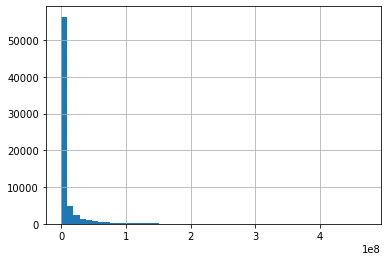

In [32]:
# Distribution
print("Median", df_combined['time_diff'].median())
df_combined['time_diff'].dt.total_seconds().hist(bins=50)

In [33]:
# Filter out first two and last two percentiles
df_combined = df_combined[(df_combined['time_diff'] > df_combined['time_diff'].quantile(.02)) & (df_combined['time_diff'] < df_combined['time_diff'].quantile(.98))]

In [34]:
# Create a binary resolving_time column which is based on the resolving time vs median
median = df_combined['time_diff'].median()
df_combined['resolving_time'] = df_combined['time_diff'].apply(lambda val: "long" if val > median else "short") 

### RQ2 Fixing Time Data

In [35]:
labeled_data = pd.read_csv("issues_data_labeled_english.csv")[['_id', 'sentiment']]
labeled_data.head()

,_id,sentiment
0,58bfca950ccb2667fe269dd8,neutral
1,58bfca950ccb2667fe269ddd,neutral
2,58bfca950ccb2667fe269dde,neutral
3,58bfca970ccb2667fe269df6,neutral
4,58bfca980ccb2667fe269e11,neutral


In [36]:
df_output = df_combined.copy()
df_output['_id'] = df_output['_id'].astype(str)
df_output = pd.merge(left=df_output, right=labeled_data, left_on='_id', right_on='_id')

In [37]:
print("Nr of lines output data", len(df_output.index))
print("Neutral:", len(df_output[df_output['sentiment'] == 'neutral'].index), "positive:", len(df_output[df_output['sentiment'] == 'positive'].index), "negative:", len(df_output[df_output['sentiment'] == 'negative'].index))

Nr of lines output data 66749
Neutral: 64538 positive: 1452 negative: 759


In [38]:
df_output.to_csv("fixing_time_sentiment_data.csv", index=False)